In [59]:
"""
Add path for code repository
"""
import sys
sys.path.insert(0, "C:\\code\\python_for_the_financial_economist")

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# to download data
import pandas_datareader as pdr

# working with dates and relative dates
from datetime import datetime, timedelta, date
from dateutil.relativedelta import relativedelta

"""
Load own functions/packages
"""

# functionality for plotting fanchart
from codelib.visualization.base import fan_chart

# set plotting style
from codelib.visualization.layout import DefaultStyle, default_colors
DefaultStyle();

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Plotting the development of S&P 500

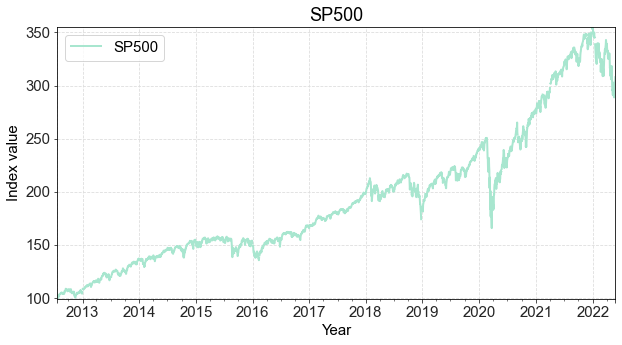

In [48]:
start = date(2012, 7, 22) # SP500 only available after this date

# Set series codes
series = 'SP500'

# Import the data
prices = pdr.DataReader(series, 'fred', start=start)

prices = prices / prices.iloc[0, :] * 100 # normalize base year

# Plot the price 
ax = prices.plot(title="SP500", figsize=(10, 5), xlabel="Year"); 
ax.set_ylabel('Index value'); 

In [49]:
prices.tail()

,SP500
DATE,
2022-05-23,294.238516
2022-05-24,291.849066
2022-05-25,294.607262
2022-05-26,300.465006
2022-05-27,307.899180


# Forecast using a simple random walk 

We assume that we can write the natural logarithm of the S&P 500 index as 

$$
\ln y_t = \alpha + \ln y_{t-1} + \varepsilon_t, \; \; \varepsilon_t \sim \mathit{N}(0, \sigma^2)
$$

or alternatively as

$$
\Delta \ln y_t = \alpha + \varepsilon_t
$$

Below we estimate the parameters and simulate observations for the next year. 

In [50]:
# calculate differences in log-prices
log_prices = np.log(prices)
diff_log_prices = log_prices - log_prices.shift(1)

In [51]:
# calculate alpha 
alpha = diff_log_prices.dropna().mean().values[0]

# calculate sigma
sigma = np.sqrt(((diff_log_prices - alpha)**2).mean().values[0])

In [52]:
alpha

0.00044868014330719746

In [53]:
sigma

0.010705487684092806

In [81]:
# generate forecasted values for the next year
# 10,000 paths of daily returns over the next year
forecasted_log_diff = np.random.normal(loc=alpha * 250 / 365, scale=sigma * np.sqrt(250 / 365), size=(1000, 365))
forecasted_prices = prices.values[-1] * np.exp(np.cumsum(forecasted_log_diff, axis=1))

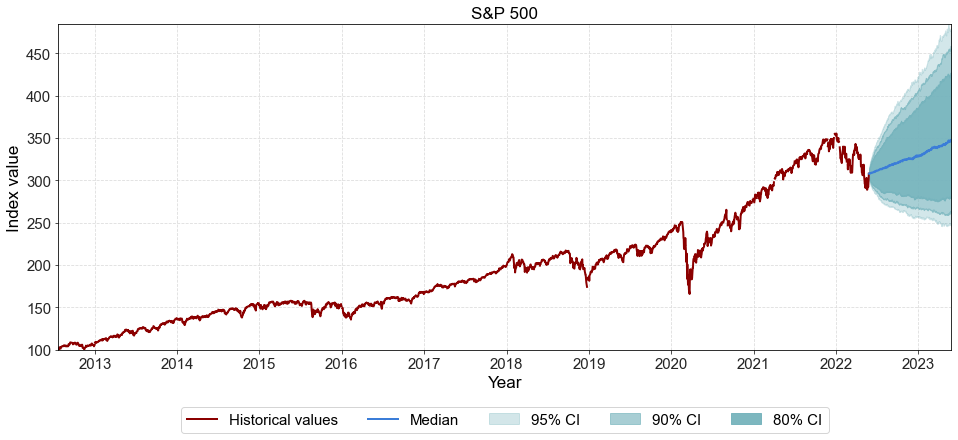

In [82]:
percentiles = np.percentile(forecasted_prices, [2.5, 5, 10, 50, 90, 95, 97.5], axis=0)
time_points = [prices.index[-1] + timedelta(days = d) for d in range(1, 366)]


"""
Plot fan chart
"""

fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(prices.index, prices.values, color="darkred", label="Historical values")

fan_chart(time_points,
          percentiles,
          color=default_colors['cyan'],
          color_median=default_colors['dark_blue'],
          labels=['95% CI', '90% CI', '80% CI', 'Median'],
          ax=ax)

ax.set_xlabel("Year", size=17)
ax.set_ylabel("Index value", size=17)
ax.set_title("S&P 500", size=17)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=15);